In [1]:
using StatsBase
using LinearAlgebra
using JuMP
using Gurobi
using CSV
using Distances
using PyPlot
using SparseArrays
using Printf
using DataFrames

In [2]:
struct Pile
    points::Matrix{Float64} # 2 x n matrix where each column is a point
    weights::Vector{Float64}
end
Base.length(p::Pile) = length(p.weights)

function Base.rand(::Type{Pile}; n_points = rand(1:5),
                                 points = rand(2,n_points),
                                use_rand = true)
    if use_rand
        
        weights = rand(n_points)
#         weights = weights/sum(weights)
    else
        weights = ones(n_points)
#         weights = weights/sum(weights)
    end
    return Pile(points, weights)
end

P = rand(Pile, n_points = 10, use_rand = false)
Q = rand(Pile, n_points = 15, use_rand = false)
cost = pairwise(Euclidean(), P.points, Q.points; dims=2)

10×15 Array{Float64,2}:
 0.336138   0.541457  0.389459  0.698314  …  0.487582  0.409233  0.131152
 0.0961621  0.689887  0.384739  0.833445     0.729194  0.237664  0.372118
 0.830872   0.291178  0.868145  0.389724     0.210769  0.811548  0.410885
 0.670735   0.619126  0.499443  0.766866     0.2616    0.751564  0.249939
 0.324942   0.652526  0.760591  0.744036     0.914894  0.14096   0.605194
 0.389282   0.753157  0.834495  0.833822  …  1.02802   0.222999  0.715465
 0.840216   0.3017    1.13405   0.226656     0.776885  0.700006  0.71399 
 0.597472   0.34832   0.627234  0.5015       0.239829  0.609298  0.161571
 0.755901   0.15468   1.00907   0.148107     0.628336  0.639808  0.572592
 0.909202   0.616798  0.76754   0.730513     0.14288   0.957773  0.44966 

In [10]:
P_dat = CSV.read("../data/artificial/P_new.csv"; header=false)
P_points = convert(Matrix, P_dat)'


Q_dat = CSV.read("../data/artificial/Q_new.csv"; header=false)
Q_points = convert(Matrix, Q_dat)'

P = rand(Pile, n_points = size(P_points)[2], points = P_points,use_rand = false)
Q = rand(Pile, n_points = size(Q_points)[2], points = Q_points, use_rand = false)

cost = pairwise(Euclidean(), P.points, Q.points; dims=2)

7×23 Array{Float64,2}:
 1.80278  2.4041    2.9731    3.45206   …  0.854242  1.24648   1.80278
 1.41421  1.95586   2.49755   2.96265      0.911774  1.00402   1.41421
 1.11803  1.53982   2.03375   2.47749      1.19705   0.981009  1.11803
 1.0      1.19026   1.59202   1.99964      1.59202   1.19026   1.0    
 1.11803  0.981009  1.19705   1.53597      2.03375   1.53982   1.11803
 1.41421  1.00402   0.911774  1.10446   …  2.49755   1.95586   1.41421
 1.80278  1.24648   0.854242  0.761876     2.9731    2.4041    1.80278

In [11]:
solCount = 6000
m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0))

@variable(m, X[axes(cost,1), axes(cost,2)] ≥ 0, Int)
@objective(m, Min, cost ⋅ X)
@constraint(m,sum(X) .== min(sum(P.weights), sum(Q.weights)))
@constraint(m, X * ones(Int, length(Q)) .<= P.weights)
@constraint(m, X'ones(Int, length(P)) .<= Q.weights);
optimize!(m)
obj = objective_value(m)

solution_pool = zeros(solCount, length(P),length(Q))
cnt = 0
obj = objective_value(m)

for i in 0:(solCount-1)
    try
        setparam!(m.moi_backend.inner,"SolutionNumber", i)
        xn = Gurobi.get_dblattrarray(m.moi_backend.inner, "Xn", 1, length(X))
        xn_val = Gurobi.get_dblattr(m.moi_backend.inner, "PoolObjVal")
        if(round(xn_val,digits=1) != round(obj, digits=1))
            println(cnt , " solution(s) selected")
            break
        end
        default = zeros(length(P),length(Q))
        for i in 0:length(P)-1
            default[i+1,:] = xn[(i*length(Q))+1:(i+1)*length(Q)]
        end
        solution_pool[i+1,:,:] = default
        cnt+=1
    catch 
        break
    end
end
sol_pool = deepcopy(solution_pool[1:cnt,:,:]);


Optimize a model with 31 rows, 161 columns and 483 nonzeros
Variable types: 0 continuous, 161 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+00]
Presolve time: 0.00s
Presolved: 31 rows, 161 columns, 483 nonzeros
Variable types: 0 continuous, 161 integer (161 binary)

Root relaxation: objective 6.309317e+00, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       6.3093165    6.30932  0.00%     -    0s
Optimal solution found at node 0 - now completing solution pool...
     0     0          -    0         6.30932    6.30932  0.00%     -    0s
     0     0          -    0         6.30932    6.30932  0.00%     -    0s
     0     2          -    0         6.30932    6.30932  0.00%     -    0s

Explored 107208

In [12]:
size(sol_pool)

(192, 7, 23)

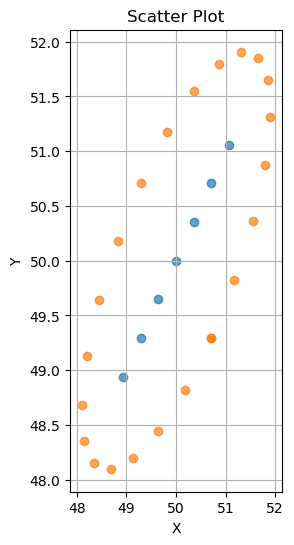

In [13]:
fig = figure("pyplot_scatterplot",figsize=(6,6))
ax = PyPlot.axes()
subplot(122)
# ax = fig[:add_subplot](1,2,2);
scatter(P.points[1,:],P.points[2,:],alpha=0.7)
scatter(Q.points[1,:],Q.points[2,:],alpha=0.7)

PyPlot.title("Scatter Plot")
xlabel("X")
ylabel("Y")
grid(true)
# gcf() # Needed for IJulia to plot inline

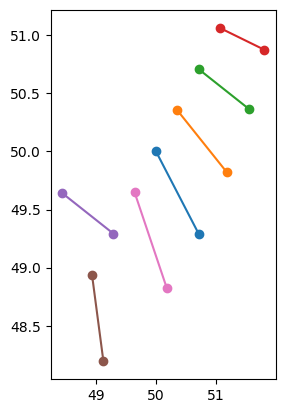

In [14]:
solOther = sparse(sol_pool[rand(1:cnt),:,:])
for (x,y,v) in zip(findnz(solOther)...)
    
    x_pos = [P.points[:,x][1], Q.points[:,y][1]]
    y_pos = [P.points[:,x][2], Q.points[:,y][2]]
    subplot(122)
    scatter(x_pos, y_pos)
    plot(x_pos, y_pos)
end

In [15]:
allSolutions = zeros(cnt, size(P.points)[2]*4)

for index in 1:cnt
    solOther = sparse(sol_pool[index,:,:])
    line = zeros(0)
    for (x,y,v) in zip(findnz(solOther)...)
        P_pos = [P.points[:,x][1], P.points[:,x][2]]
        Q_pos = [Q.points[:,y][1], Q.points[:,y][2]]
        append!(line, P_pos)
        append!(line, Q_pos)
    end
    allSolutions[index,:] = line
end
df = DataFrame(allSolutions)
println("Count of solutions:$(size(df)[1])")
CSV.write("../data/artificial/solutions.csv",  df, writeheader=false)

Count of solutions:192


"../data/artificial/solutions.csv"